In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "EIL"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn017871,MSNRMMMFDEMGFCGDLDFLSAPLGDGDVTASQTEPEAVVDDDYSD...,627,1
1,Achn018171,MDANGLDDNSDIEVDEIRCGNIVERDVSDEEIEAEDLERRMWKDRI...,638,1
2,Achn018431,MIMFDEMGFCGDLDFFSAPLGEGDMAAPQTEPEVVMDDDYSDEEID...,619,1
3,Achn123771,MGVMEEIGVDISSDIEVDEIRCENIAEKDVSDEEIEAEDLERRMWK...,608,1
4,Achn171621,MIELCEELNDPPSSDDEDDKLGYDELKKRIWKDRVRLQKLKAKHEA...,492,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
343,0.005164,0.0,0.000000,0.003442,0.000000,0.003442,0.0,0.003442,0.006885,0.001721,...,0.000000,0.001721,0.001721,0.003442,0.000000,0.001721,0.000000,0.000000,0.0,0.0
1108,0.000000,0.0,0.000000,0.004762,0.000000,0.000000,0.0,0.004762,0.004762,0.004762,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004762,0.000000,0.004762,0.0,0.0
904,0.006590,0.0,0.004942,0.006590,0.000000,0.001647,0.0,0.004942,0.004942,0.001647,...,0.001647,0.003295,0.000000,0.000000,0.001647,0.000000,0.000000,0.000000,0.0,0.0
2316,0.003058,0.0,0.003058,0.003058,0.003058,0.003058,0.0,0.000000,0.006116,0.000000,...,0.003058,0.003058,0.000000,0.000000,0.003058,0.000000,0.003058,0.000000,0.0,0.0
1022,0.002028,0.0,0.000000,0.002028,0.000000,0.002028,0.0,0.002028,0.004057,0.002028,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002028,0.000000,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1956, 441)
X_test: (489, 441)
y_train: (1956,)
y_test: (489,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 11s 472ms/step - accuracy: 0.5000 - loss: 0.6930

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5458 - loss: 0.6838 - val_accuracy: 0.7245 - val_loss: 0.5912


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6250 - loss: 0.6308

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.5070 - val_accuracy: 0.9643 - val_loss: 0.1610


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8906 - loss: 0.2821

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9598 - loss: 0.1485 - val_accuracy: 0.9770 - val_loss: 0.0660


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0255

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0720 - val_accuracy: 0.9949 - val_loss: 0.0321


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0199

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0493 - val_accuracy: 0.9949 - val_loss: 0.0254


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0189

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0445 - val_accuracy: 0.9719 - val_loss: 0.0709


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0535

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0430 - val_accuracy: 0.9974 - val_loss: 0.0193


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0107

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0167 - val_accuracy: 0.9923 - val_loss: 0.0182


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0067

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9934 - loss: 0.0240 - val_accuracy: 0.9949 - val_loss: 0.0161


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0046

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0152 - val_accuracy: 0.9949 - val_loss: 0.0200


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0031

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0109 - val_accuracy: 0.9898 - val_loss: 0.0214


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0024

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 0.9745 - val_loss: 0.0535


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0087

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0116 - val_accuracy: 0.9923 - val_loss: 0.0221


Epoch 14/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0020

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0088 - val_accuracy: 0.9923 - val_loss: 0.0277


Epoch 15/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0075 - val_accuracy: 0.9821 - val_loss: 0.0419


Epoch 16/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0043

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0079 - val_accuracy: 0.9923 - val_loss: 0.0194


Epoch 17/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0472e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0072 - val_accuracy: 0.9898 - val_loss: 0.0300



[Train Accuracy: 99.81% - Test Accuracy: 98.98%]


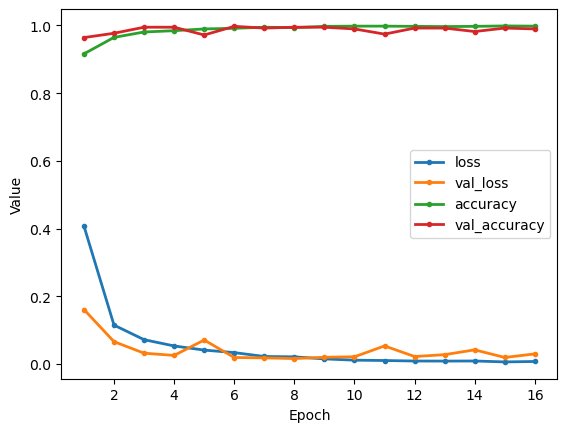

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
343,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.001724,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
904,0.0,0.0,0.0,0.00165,0.000000,0.0,0.0,0.001650,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2316,0.0,0.0,0.0,0.00000,0.003067,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.002033,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1956, 8587)
X_test: (489, 8587)
y_train: (1956,)
y_test: (489,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,198,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241,793 (8.55 MB)

 Trainable params: 2,241,793 (8.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.5312 - loss: 0.6932

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5455 - loss: 0.6925   

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6011 - loss: 0.6901

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6468 - loss: 0.6862 - val_accuracy: 0.9796 - val_loss: 0.5891


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.5825

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9850 - loss: 0.5489 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9854 - loss: 0.5004

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9854 - loss: 0.4615 - val_accuracy: 0.9847 - val_loss: 0.0830


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0591

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0549 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9956 - loss: 0.0488

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9954 - loss: 0.0452 - val_accuracy: 0.9949 - val_loss: 0.0215


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0080

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0092 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0079

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9993 - loss: 0.0071 - val_accuracy: 0.9949 - val_loss: 0.0205


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0019

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9949 - val_loss: 0.0126


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0035

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0022 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9949 - val_loss: 0.0222


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.1352e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9001e-04 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4965e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6190e-04 - val_accuracy: 0.9949 - val_loss: 0.0282


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.1991e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3709e-04 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3004e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1977e-04 - val_accuracy: 0.9949 - val_loss: 0.0267


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.9838e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9057e-04 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6540e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7930e-04 - val_accuracy: 0.9949 - val_loss: 0.0301


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.7597e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4015e-04 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1594e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0701e-04 - val_accuracy: 0.9898 - val_loss: 0.0350


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.8981e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0364e-04 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0446e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1456e-04 - val_accuracy: 0.9949 - val_loss: 0.0244


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.0682e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6757e-04 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1456e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2304e-04 - val_accuracy: 0.9949 - val_loss: 0.0306


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.1641e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2976e-04 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5406e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5886e-04 - val_accuracy: 0.9949 - val_loss: 0.0288



[Train Accuracy: 100.00% - Test Accuracy: 99.39%]


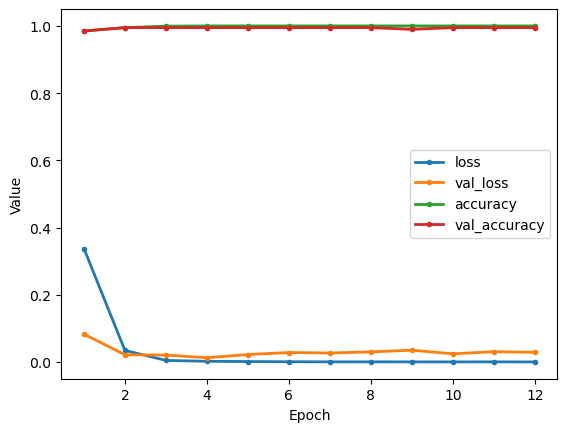

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      31,610,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,652,097 (120.74 MB)

 Trainable params: 31,652,097 (120.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 15s 646ms/step - accuracy: 0.5000 - loss: 0.6931

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5117 - loss: 0.6930  

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5130 - loss: 0.6930

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5137 - loss: 0.6929

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5153 - loss: 0.6928

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5162 - loss: 0.6926

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5171 - loss: 0.6925

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5164 - loss: 0.6924

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5165 - loss: 0.6923

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5171 - loss: 0.6922

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5171 - loss: 0.6920

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5165 - loss: 0.6919

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5157 - loss: 0.6917

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5148 - loss: 0.6916

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5152 - loss: 0.6914

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5164 - loss: 0.6912

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5191 - loss: 0.6910

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5225 - loss: 0.6907

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5264 - loss: 0.6904

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5307 - loss: 0.6901

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5352 - loss: 0.6897

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5399 - loss: 0.6893

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5447 - loss: 0.6888

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5496 - loss: 0.6884

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5588 - loss: 0.6875 - val_accuracy: 0.9872 - val_loss: 0.6225


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9844 - loss: 0.6173

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9844 - loss: 0.6151

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9861 - loss: 0.6133

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9876 - loss: 0.6106

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9889 - loss: 0.6086

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9898 - loss: 0.6063

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9907 - loss: 0.6037

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9911 - loss: 0.6013

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9915 - loss: 0.5986

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9917 - loss: 0.5959

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9920 - loss: 0.5929

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9921 - loss: 0.5898

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9921 - loss: 0.5866

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9921 - loss: 0.5833

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9921 - loss: 0.5798

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9921 - loss: 0.5762

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9921 - loss: 0.5724

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9922 - loss: 0.5685

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9923 - loss: 0.5647

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9923 - loss: 0.5608

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9924 - loss: 0.5568

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9925 - loss: 0.5527

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9926 - loss: 0.5486

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9927 - loss: 0.5444

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9929 - loss: 0.5366 - val_accuracy: 0.9847 - val_loss: 0.2060


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9844 - loss: 0.1815

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9844 - loss: 0.1818

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9861 - loss: 0.1773

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9876 - loss: 0.1726

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9882 - loss: 0.1688

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9889 - loss: 0.1648

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9892 - loss: 0.1608

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9896 - loss: 0.1570

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9898 - loss: 0.1534

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9900 - loss: 0.1500

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9903 - loss: 0.1467

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9905 - loss: 0.1434

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9907 - loss: 0.1404

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9909 - loss: 0.1375

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9911 - loss: 0.1347

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9913 - loss: 0.1320

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9914 - loss: 0.1294

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9916 - loss: 0.1269

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9917 - loss: 0.1245

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9918 - loss: 0.1223

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9919 - loss: 0.1201

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9920 - loss: 0.1179

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9921 - loss: 0.1159

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9922 - loss: 0.1139

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9923 - loss: 0.1120

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9924 - loss: 0.1103 - val_accuracy: 0.9847 - val_loss: 0.0488


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0109

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0103

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0099

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0096

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0097

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0096

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0095

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0093

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0091

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0089

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0087

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0085

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0084

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0083

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0082

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0081

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0080

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0079

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0078

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0077

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0076

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0075

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0074

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0073

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.9872 - val_loss: 0.0346


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 0.0015

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0018

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0019

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0018

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0018

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0018

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0018

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 0.0018

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 0.0018

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0018

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0018

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0017

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0017

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9847 - val_loss: 0.0380


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 5.2761e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 7.3102e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.1435e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.4939e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.6039e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.6024e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.6555e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 9.1402e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 9.4429e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 9.8231e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0010    

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0010

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0010

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9847 - val_loss: 0.0453


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0020

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0015

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0013

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0012

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0011

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0010

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 9.7324e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 9.2751e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 8.9136e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 8.6189e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 8.3679e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 8.1497e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.9444e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.7838e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.6299e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.4953e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.3676e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.2517e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.1486e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.0683e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 7.0047e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 6.9413e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 6.8802e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 6.8214e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 6.7184e-04 - val_accuracy: 0.9847 - val_loss: 0.0422


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 5.4561e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 4.5737e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.2997e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.4222e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.3748e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.2976e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.2728e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.2302e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.1878e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1754e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1691e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1572e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1505e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1366e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1171e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.0999e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.0762e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.0555e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.0326e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.0142e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.9948e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.9736e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.9525e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.9338e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 3.9003e-04 - val_accuracy: 0.9847 - val_loss: 0.0436


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 3.6116e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.4487e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.3413e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.1867e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.0511e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.9540e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.8852e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.9168e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.9228e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.9615e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0008e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0250e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0369e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0529e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0589e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0633e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0642e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0628e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0593e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0520e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0467e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0399e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0324e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.0240e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 3.0078e-04 - val_accuracy: 0.9847 - val_loss: 0.0548


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 1.8496e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 1.7970e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.1882e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.6040e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.0322e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.1951e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.2586e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 4.2801e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 4.2632e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.2296e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1834e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1308e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.1037e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.0683e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.0279e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.9888e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.9483e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.9164e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.8834e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.8495e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.8155e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.7807e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.7468e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.7138e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 3.6577e-04 - val_accuracy: 0.9847 - val_loss: 0.0403


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 2.0777e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.0826e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.0804e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.0624e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.0571e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.0429e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.0379e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.0411e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.0325e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.0462e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.0892e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1203e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1377e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1526e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1611e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1645e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1643e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1599e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1539e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1490e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1432e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1367e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1299e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1236e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 2.1117e-04 - val_accuracy: 0.9847 - val_loss: 0.0495



[Train Accuracy: 100.00% - Test Accuracy: 99.18%]


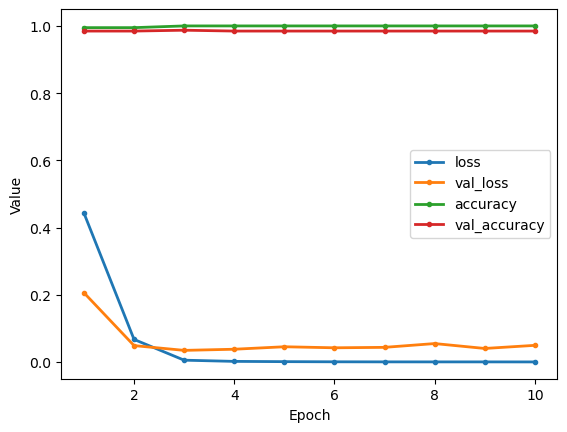

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/EIL/report_VZT78G3I.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################